In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt

Here we implement a simple Neural network to handle the classification of anomalies in the financial markets.

The  financial market dataset contains data from 11-01-2000 to 20-04-2021  while the data for the future and the hedge funds indexes goes from  23-10-2007 to 20-04-2021.

The idea is to train and validate the classifier with the first part of the data 11-01-2000 to 23-10-2007 and then use the rest of the data for the test.

We realize this separation leads to a not optimal ratio between training/validation and test and we expect that with an higher amount of training data our model could have performed better. Unfortunately we will have to work with this data, since we would like to be able to test the performance of the kalman filter against the lasso regression on the same set.

In [9]:
data = pd.read_excel('FinancialMarketData.xlsx', 2)
Y = data['Y'].values
X = data.drop(columns=["Y", "Data"]).values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## In this section here we divide the whole dataset in train validation and test set.
# Split the data into training and validation sets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X_scaled, Y, test_size=705/1111, shuffle=False)

# Calculate the proportion for the further split of the remaining part
remaining_ratio = 348 / (348 + 58) 

# Now, split the remaining part into training and validation sets with the required proportion
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=116/406, shuffle=False)


#We consider a matrix of possible number of layers and nodes for each layer to train our model.
#We decided to keep a quite low complexity to avoid overfitting.
layer=[1,2,3,4];
node=[15,30,45];
auc_scores={}

for layers in layer:
    for nodes in node:
        hidden_layers = (nodes,) * layers
        #In these neural networks we use as the last activation function a sigmoid function (since we are dealing with a classification problem) while after some trial and error we decided to adopt identity function for the others activation functions.
        
        model = MLPClassifier(
        hidden_layer_sizes=hidden_layers, activation='identity', solver='adam', random_state=42,max_iter=1500)

        # Train the model
        model.fit(X_train, Y_train)

        # Predict probabilities on the validation set
        Y_pred_val_prob = model.predict_proba(X_val)[:, 1]

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(Y_val, Y_pred_val_prob)
        auc_scores[(layers,nodes)] = roc_auc_score(Y_val, Y_pred_val_prob)
    

    

Here we have the AUC score for different numbers of layers and nodes

In [3]:
auc_scores

{(1, 15): 0.8348214285714286,
 (1, 30): 0.9308035714285714,
 (1, 45): 0.7299107142857142,
 (2, 15): 0.8258928571428572,
 (2, 30): 0.8526785714285715,
 (2, 45): 0.6674107142857142,
 (3, 15): 0.7678571428571428,
 (3, 30): 0.8794642857142857,
 (3, 45): 0.6830357142857143,
 (4, 15): 0.5959821428571428,
 (4, 30): 0.90625,
 (4, 45): 0.6138392857142857}

We choose to consider the 1 layer 30 nodes model as it seems to be generalizing well to the validation set.

In [10]:
model = MLPClassifier(
        hidden_layer_sizes=(1, 30), activation='identity', solver='adam', random_state=42,max_iter=1500)

model.fit(X_train, Y_train)

Y_pred_test_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test_prob)
auc_score = roc_auc_score(Y_test, Y_pred_test_prob)

This is the final AUC score that our model managed to obtain in the final test set

In [5]:
auc_score

0.8169138500162723

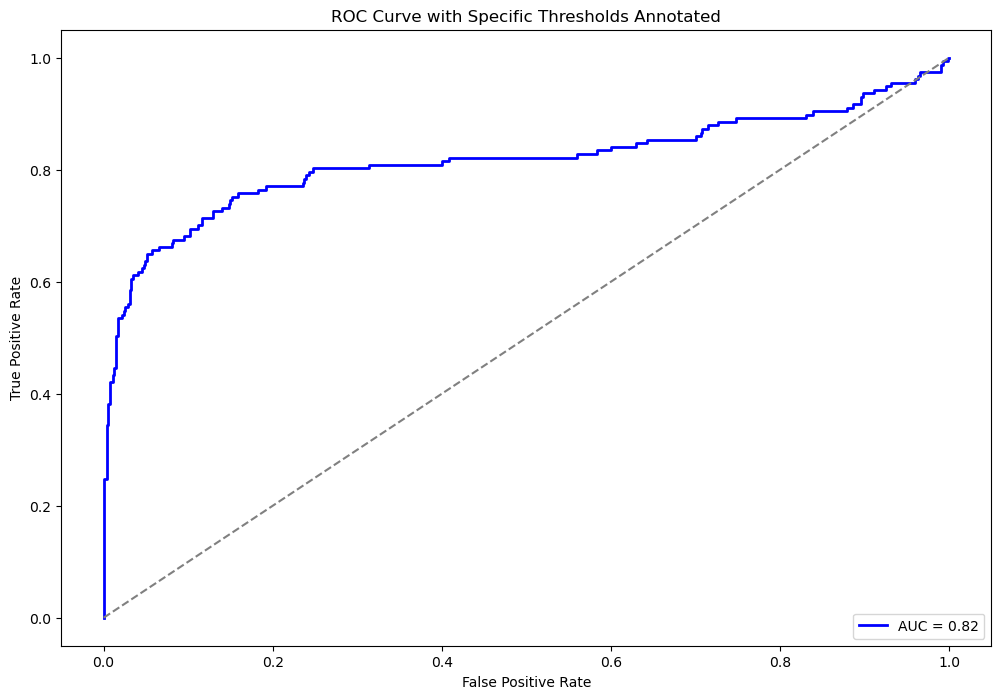

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Specific Thresholds Annotated')
plt.legend(loc='lower right')
plt.grid(None)
plt.grid(None)
plt.show()

Finally, we create an Excel spreadsheet with the classification performed by our model with different thresholds.
The idea is to choose the optimal threshold by finding what works best in the rolling window validation set for the Kalman filter and then see how it performs in the test set.


In [12]:
#We consider thresholds from 0.1 to 0.9 and we consider 51 of them 
thresholds = np.linspace(0.1,0.9,51)
Y_pred_test_binary={}
for threshold in thresholds:
    Y_pred_test_binary[threshold] = np.where(Y_pred_test_prob > threshold, 1, 0)
Valori_Predetti= pd.DataFrame(Y_pred_test_binary)
Valori_Predetti.to_excel("Valori_Predetti.xlsx",index=False)

df_originale = pd.read_excel("Valori_Predetti.xlsx")
df_validation = df_originale.iloc[:478]
df_test = df_originale.iloc[478:].copy()

with pd.ExcelWriter("Valori_Predetti.xlsx", engine="xlsxwriter") as writer:
    # 
    df_validation.to_excel(writer, sheet_name="Validation", index=False)
    # 
    df_test.to_excel(writer, sheet_name="Test", index=False)